# ROI-based GLM comparison
Natalia Vélez, November 2022

In [12]:
%matplotlib inline

import os,sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append('..')
from utils import gsearch, print_list, read_json, str_extract, int_extract

sns.set_context('talk')
sns.set_style('white')

Load Neurosynth ROI labels:

In [2]:
roi_dir = '/n/gershman_ncf/User/nvelezalicea/fmri_analysis/roi_library/fmriprep_space/'
label_files = gsearch(roi_dir, 'neurosynth*_label.txt')
label_files.sort()

label_list = []

for f in label_files:
    region = str_extract('neurosynth_r[0-9]{2}', f)
    label = np.loadtxt(f, dtype=str, delimiter='\n')
    label = str(label)

    label_list.append((region, label))
    
label_df = pd.DataFrame(label_list, columns=['roi', 'roi_label']).sort_values(by='roi_label').reset_index(drop=True)
label_df['roi'] = label_df['roi'].astype('category').cat.reorder_categories(label_df.roi.values)
label_df['roi_label'] = label_df['roi_label'].str.replace('Left', 'L')
label_df['roi_label'] = label_df['roi_label'].str.replace('Right', 'R')
label_df['roi_label'] = label_df['roi_label'].astype('category')
print(label_df.shape)
label_df

(7, 2)


,roi,roi_label
0,neurosynth_r41,L Angular Gyrus
1,neurosynth_r49,L Frontal Medial Cortex
2,neurosynth_r01,L Frontal Pole
3,neurosynth_r61,L Precuneous Cortex
4,neurosynth_r15,L Temporal Pole
5,neurosynth_r42,R Angular Gyrus
6,neurosynth_r16,R Temporal Pole


GLM labels:

In [3]:
belief_levels = ['T', 'T+B']
model_labels = [(idx, m) for idx,m in enumerate(belief_levels)]
model_label_df = pd.DataFrame(model_labels, columns=['model_idx', 'full_label'])
#pmod_levels =  ['Full', 'Belief', 'KL']

# model_labels = [(belief, pmods) for belief in belief_levels for pmods in pmod_levels]
# model_label_df = pd.DataFrame(model_labels, columns=['belief_source', 'pmod']).reset_index().rename(columns={'index': 'model_idx'})
# model_label_df['full_label'] = model_label_df.apply(lambda row: '%s: %s' % (row.belief_source, row.pmod), axis=1)

print(model_label_df.shape)
model_label_df

(2, 2)


,model_idx,full_label
0,0,T
1,1,T+B


## QA: Correlations between regressors

Data wrangling:

In [4]:
model_reg = (
    pd.read_csv('../2_behavioral/outputs/model_regressor_values.csv')
    .drop(columns=['problem', 'pH','KL', 'logp'])
    .assign(source='GLM 1: Model-based')
)

control_reg = (
    pd.read_csv('../2_behavioral/outputs/control_regressor_values.csv')
    .drop(columns=['KL', 'pTrue_unscaled', 'KL_unscaled'])
    .rename(columns={'pTrue': 'control'})
)

student_reg = (
    pd.read_csv('../3_student/outputs/student_regressors_values.csv')
    .rename(columns={'block_no': 'block_idx', 'trial_no': 'ex_idx'})
    .drop(columns=['stimuli', 'KL'])
    .assign(source='GLM 2: Human learners')
)
student_reg['subject'] = student_reg.subject.apply(lambda x: int_extract('(?<=sub-)[0-9]{2}', x))

reg_df = pd.concat([model_reg, student_reg]).merge(control_reg)
print(reg_df.shape)
reg_df.head()

(6418, 10)


,subject,run,block_idx,ex_idx,pTrue,pTrue_unscaled,KL_unscaled,source,problem,control
0,1,1,0,0,-0.126543,0.333333,1.740425,GLM 1: Model-based,22,-0.25463
1,1,1,0,0,-0.211405,NaN,NaN,GLM 2: Human learners,22,-0.25463
2,1,1,0,1,0.040123,0.500000,2.433523,GLM 1: Model-based,22,-0.00463
3,1,1,0,1,-0.069094,NaN,NaN,GLM 2: Human learners,22,-0.00463
4,1,1,1,0,0.040123,0.500000,3.565749,GLM 1: Model-based,18,-0.25463


## QA: How often did beliefs increase with time?

Measure change in posterior belief

In [5]:
diff_reg = reg_df.copy()
diff_reg['diff'] = diff_reg.groupby(['subject', 'run', 'block_idx', 'source'])['pTrue'].diff()
diff_reg = diff_reg.dropna(subset=['diff'])
diff_reg['outcome'] = np.where(diff_reg['diff'] > 0, 'increased', np.where(diff_reg['diff'] == 0, 'no change', 'decreased'))

print(diff_reg.shape)
diff_reg.head(10)

(4188, 12)


,subject,run,block_idx,ex_idx,pTrue,pTrue_unscaled,KL_unscaled,source,problem,control,diff,outcome
2,1,1,0,1,0.040123,0.5,2.433523,GLM 1: Model-based,22,-0.00463,0.166667,increased
3,1,1,0,1,-0.069094,NaN,NaN,GLM 2: Human learners,22,-0.00463,0.142312,increased
6,1,1,1,1,0.040123,0.5,0.000000,GLM 1: Model-based,18,-0.00463,0.000000,no change
7,1,1,1,1,-0.158416,NaN,NaN,GLM 2: Human learners,18,-0.00463,-0.035468,decreased
8,1,1,1,2,0.040123,0.5,0.000000,GLM 1: Model-based,18,0.24537,0.000000,no change
9,1,1,1,2,-0.099848,NaN,NaN,GLM 2: Human learners,18,0.24537,0.058567,increased
12,1,1,2,1,0.540123,1.0,5.041377,GLM 1: Model-based,1,-0.00463,0.666667,increased
13,1,1,2,1,0.398331,NaN,NaN,GLM 2: Human learners,1,-0.00463,0.642386,increased
14,1,1,2,2,0.540123,1.0,0.000000,GLM 1: Model-based,1,0.24537,0.000000,no change
15,1,1,2,2,0.498331,NaN,NaN,GLM 2: Human learners,1,0.24537,0.100000,increased


How often did belief increase vs. decrease, stay the same? 

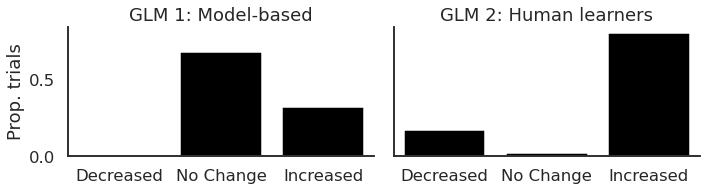

In [13]:
outcome_counts = diff_reg.groupby(['source', 'outcome'])['pTrue'].agg('count').reset_index()
outcome_counts['p_outcome'] = outcome_counts['pTrue']/outcome_counts.groupby('source').pTrue.transform('sum')
outcome_counts['outcome'] = outcome_counts.outcome.str.title().astype('category').cat.reorder_categories(['Decreased', 'No Change', 'Increased'])

g = sns.catplot(data=outcome_counts, x='outcome', y='p_outcome', col='source', kind='bar', fc='k', height=3, aspect=5/3)
g.set_titles('{col_name}')
g.set_axis_labels(x_var='', y_var='Prop. trials')

plt.savefig('plots/belief_change.pdf', bbox_inches='tight')

## Model comparison

Find model evidences:

In [8]:
evidence_files = gsearch('outputs/glm_comparison/*.json')
evidence_files.sort()

print_list(evidence_files)

Found 30 items
outputs/glm_comparison/roi-DMPFC_contrast-empiricalVcontrol_desc-PXP.json
outputs/glm_comparison/roi-DMPFC_contrast-modelVcontrol_desc-PXP.json
outputs/glm_comparison/roi-LTPJ_contrast-empiricalVcontrol_desc-PXP.json
outputs/glm_comparison/roi-LTPJ_contrast-modelVcontrol_desc-PXP.json
outputs/glm_comparison/roi-MMPFC_contrast-empiricalVcontrol_desc-PXP.json
outputs/glm_comparison/roi-MMPFC_contrast-modelVcontrol_desc-PXP.json
outputs/glm_comparison/roi-PC_contrast-empiricalVcontrol_desc-PXP.json
outputs/glm_comparison/roi-PC_contrast-modelVcontrol_desc-PXP.json
outputs/glm_comparison/roi-RSTS_contrast-empiricalVcontrol_desc-PXP.json
outputs/glm_comparison/roi-RSTS_contrast-modelVcontrol_desc-PXP.json
...


Load data:

In [9]:
evidence_list = [read_json(f) for f in evidence_files]
evidence_df = pd.DataFrame(evidence_list)

# clean up variables
# evidence_df['p_model'] = evidence_df.pxp.apply(lambda x: x[0])
evidence_df['roi'] = evidence_df.roi.str.replace('bilateral_', '')
is_ns = evidence_df.roi.str.contains('neurosynth')
#evidence_df['roi_set'] = np.where(evidence_df.roi.str.contains('neurosynth_'), 'Neurosynth', 'Functional')
# evidence_df['contrast'] = evidence_df.contrast.str.capitalize()

print(evidence_df.shape)
evidence_df

(30, 9)


,roi,contrast,models,alpha,exp_r,xp,pxp,bor,g
0,DMPFC,empiricalVcontrol,"[controlpTrue, empiricalBlended]","[21, 9]","[0.7, 0.3]","[0.9879402276128529, 0.012059772387147057]","[0.8652850897360493, 0.1347149102639507]",0.251373,"[[1, 0], [1, 7.738461570782915e-308], [0, 1], ..."
1,DMPFC,modelVcontrol,"[controlpTrue, blended]","[11, 19]","[0.36666666666666664, 0.6333333333333333]","[0.06802297383546874, 0.9319770261645313]","[0.3213298289008328, 0.6786701710991672]",0.586390,"[[1, 0], [0, 1], [0, 1], [0, 1], [1, 0], [0, 1..."
2,LTPJ,empiricalVcontrol,"[controlpTrue, empiricalBlended]","[19, 11]","[0.6333333333333333, 0.36666666666666664]","[0.9319770261645313, 0.06802297383546874]","[0.6786701734409668, 0.32132982655903325]",0.586390,"[[1, 0], [0, 1], [0, 1], [1, 0], [1, 0], [0, 1..."
3,LTPJ,modelVcontrol,"[controlpTrue, blended]","[13, 17]","[0.43333333333333335, 0.5666666666666667]","[0.22912915982306162, 0.7708708401769384]","[0.43680936501145257, 0.5631906349885474]",0.766713,"[[1, 0], [1, 0], [0, 1], [1, 0], [1, 0], [0, 1..."
4,MMPFC,empiricalVcontrol,"[controlpTrue, empiricalBlended]","[25, 5]","[0.8333333333333334, 0.16666666666666666]","[0.9999481420964003, 5.185790359973934e-05]","[0.9988447054814679, 0.0011552945185321194]",0.002207,"[[1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0..."
5,MMPFC,modelVcontrol,"[controlpTrue, blended]","[11, 19]","[0.36666666666666664, 0.6333333333333333]","[0.06802297383546874, 0.9319770261645313]","[0.32132982968143264, 0.6786701703185674]",0.586390,"[[1, 0], [0, 1], [1.5499452694848693e-175, 1],..."
6,PC,empiricalVcontrol,"[controlpTrue, empiricalBlended]","[22, 8]","[0.7333333333333333, 0.26666666666666666]","[0.995934970676899, 0.004065029323101067]","[0.9396914483138519, 0.060308551686148223]",0.113409,"[[1, 0], [1, 0], [1, 0], [1, 2.263865387570102..."
7,PC,modelVcontrol,"[controlpTrue, blended]","[14, 16]","[0.4666666666666667, 0.5333333333333333]","[0.35553555190563396, 0.644464448094366]","[0.4713648527461771, 0.5286351472538229]",0.801784,"[[1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [0, 1..."
8,RSTS,empiricalVcontrol,"[controlpTrue, empiricalBlended]","[26, 4]","[0.8666666666666667, 0.13333333333333333]","[0.9999923817813396, 7.618218660354674e-06]","[0.9998154883437874, 0.00018451165621250753]",0.000354,"[[1, 0], [1, 0], [1, 0], [1, 1.541033188412264..."
9,RSTS,modelVcontrol,"[controlpTrue, blended]","[21, 9]","[0.7, 0.3]","[0.9879402276128529, 0.012059772387147057]","[0.8652850892657071, 0.13471491073429284]",0.251373,"[[1, 0], [1, 0], [1, 0], [0, 1], [1, 0], [0, 1..."


Reorganize data

In [10]:
func_evidences = evidence_df[~(is_ns) & (evidence_df.contrast == 'modelVcontrol')].copy()
func_evidences = func_evidences.explode('pxp').reset_index(drop=True)
func_evidences_labels = pd.concat([model_label_df]*func_evidences.roi.nunique()).reset_index(drop=True)
func_evidences = pd.concat([func_evidences, func_evidences_labels], axis=1)
func_evidences['full_label'] = func_evidences['full_label'].astype('category').cat.reorder_categories(model_label_df.full_label.values)
func_evidences['full_label'] = func_evidences['full_label'].cat.reorder_categories(belief_levels)
func_evidences = func_evidences[func_evidences.roi != 'PC'] # only analyze ROIs w/ univariate effect
func_evidences = func_evidences[['roi', 'full_label', 'pxp']]

print(func_evidences.shape)
func_evidences.head()

(14, 3)


,roi,full_label,pxp
0,DMPFC,T,0.32133
1,DMPFC,T+B,0.67867
2,LTPJ,T,0.436809
3,LTPJ,T+B,0.563191
4,MMPFC,T,0.32133


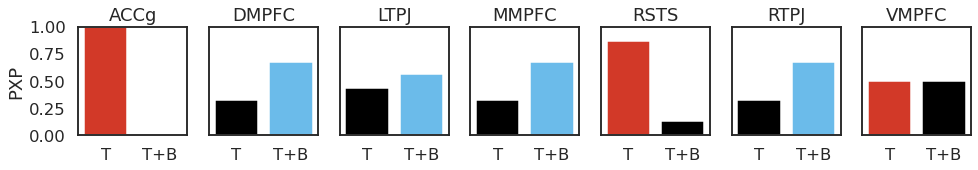

In [11]:
win_palette = ['#000000', '#56C1FF']
lose_palette = ['#EE220C', '#000000']

n_rois = func_evidences.roi.nunique()
fig,axes = plt.subplots(1, n_rois, figsize=(16,2))
ax_ctr = 0
for name,group in func_evidences.groupby('roi'):
    #ax_idx = np.unravel_index(ax_ctr, (1, n_rois))
    ax_idx = ax_ctr
    
    # choose color palette
    best_glm = group[group.pxp == group.pxp.max()].iloc[0]['full_label']
    if best_glm == belief_levels[0]:
        pal = lose_palette
    else:
        pal = win_palette
    
    if ax_idx > 0:
        ylab = ''
        yticks=[]
    else:
        ylab = 'PXP'
        yticks = [0, .25, .5, .75, 1]
    
    sns.barplot(data=group, x='full_label', y='pxp', palette=pal, ax=axes[ax_idx])
    axes[ax_idx].set(xlabel='', ylabel=ylab, title=name, ylim=(0,1), yticks=yticks)
    ax_ctr += 1
    
#fig.tight_layout()
plt.savefig('plots/glm1_model_comparison.pdf', bbox_inches='tight')